# cygnus-skew

Analyze the distribution of training samples.


In [1]:
from collections import defaultdict
from importlib import reload
import os
from typing import Dict

from matplotlib import colormaps
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats
from utils import plots, stats, tables, utils

In [2]:
# Knobs
base_dir = '/u/cmolder/GitHub/ChampSim/out/cygnus'
suites = [
    ('spec06', 'weighted'),
    ('spec17', 'weighted'),
    ('cloudsuite', 'weighted'),
    ('gap', 'weighted'),
    ('google', 'weighted')
]

features = [
    {'Delta_Path', 'PC_Delta'},
    {'PC'}
]

In [3]:
dfs = {
    # ===
    # ===== Pythia =====
    # ===
    # Pythia
    'degree1/pythia/bwaware3': tables.load_stats_csv_pythia(
        base_dir, 'degree1/pythia/bwaware3.csv', features),

    # Pythia correlation
    'degree1/cygnus/bwaware3_pythialike': tables.load_stats_csv_pythia(
        base_dir, 'degree1/pythia/bwaware3.csv', features),

    # Pythia CB
    'degree1/cygnus/bwaware3_pythialike_cb': tables.load_stats_csv_pythia(
        base_dir, 'degree1/pythia/bwaware3_cb.csv', features),

    # ===
    # ===== Pythia-Ignore =====
    # ===
    # Pythia-Ignore
    'degree1/cygnus/bwaware3_pythialike_ignorequeued': tables.load_stats_csv_pythia(
        base_dir, 'degree1/pythia/bwaware3_ignorequeued.csv', features),

    # Pythia-Ignore CB
    'degree1/cygnus/bwaware3_pythialike_ignorequeued_cb': tables.load_stats_csv_pythia(
        base_dir, 'degree1/pythia/bwaware3_ignorequeued_cb.csv', features),

    # ===
    # ===== Cygnus =====
    # ===
    # Cygnus Ideal
    'degree1/cygnus/bwaware3': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3.csv', 
        features, feature_key='cygnus_features'),


    # ===
    # ===== Cygnus-Ignore =====
    # ===
    # Cygnus-Ignore 1 Taken
    'degree1/cygnus/bwaware3_ignorequeued_sampling/1taken': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued_sampling/1taken.csv', 
        features, feature_key='cygnus_features'),
    
    # Cygnus-Ignore 1 Taken + 1 Random
    'degree1/cygnus/bwaware3_ignorequeued_sampling/2randomtaken': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued_sampling/2randomtaken.csv',
        features, feature_key='cygnus_features'),

    # Cygnus-Ignore 1 Taken + 3 Random
    'degree1/cygnus/bwaware3_ignorequeued_sampling/4randomtaken': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued_sampling/4randomtaken.csv',
        features, feature_key='cygnus_features'),

    # Cygnus-Ignore 1 Taken + 7 Random
    'degree1/cygnus/bwaware3_ignorequeued_sampling/8randomtaken': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued_sampling/8randomtaken.csv',
        features, feature_key='cygnus_features'),

    # Cygnus-Ignore 1 Random
    'degree1/cygnus/bwaware3_ignorequeued_sampling/1random': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued_sampling/1random.csv',
        features, feature_key='cygnus_features'),

    # Cygnus-Ignore Ideal
    'degree1/cygnus/bwaware3_ignorequeued': tables.load_stats_csv_pythia(
        base_dir, 'degree1/cygnus/bwaware3_ignorequeued.csv',
        features, feature_key='cygnus_features'),
}

# Plots (suites)

In [8]:
skew_df = {
    'Ideal': dfs['degree1/cygnus/bwaware3_ignorequeued']['Delta_Path, PC_Delta'],
    'Taken + 7 Random': dfs['degree1/cygnus/bwaware3_ignorequeued_sampling/8randomtaken']['Delta_Path, PC_Delta'],
    'Taken + 3 Random': dfs['degree1/cygnus/bwaware3_ignorequeued_sampling/4randomtaken']['Delta_Path, PC_Delta'],
    'Taken + 1 Random': dfs['degree1/cygnus/bwaware3_ignorequeued_sampling/2randomtaken']['Delta_Path, PC_Delta'],
    '1 Random': dfs['degree1/cygnus/bwaware3_ignorequeued_sampling/1random']['Delta_Path, PC_Delta'],
    'Taken': dfs['degree1/cygnus/bwaware3_ignorequeued_sampling/1taken']['Delta_Path, PC_Delta'],
    'Pythia (Taken ε-greedy)': dfs['degree1/pythia/bwaware3']['Delta_Path, PC_Delta'],
}

## Variation vs. IPC

In [9]:
def plot_variations_v2(data_df, metric='cv', dpi=192, figsize=(12, 4)):
    # Get means
    mean_pythia = tables.gen_table_metric_all(data_df, suites, f'pythia_reward_{metric}').dropna()
    mean_cygnus = tables.gen_table_metric_all(data_df, suites, f'cygnus_reward_{metric}').dropna()
    means_var = pd.concat([mean_pythia, mean_cygnus], axis=0)['all']
    means_ipc = tables.gen_table_metric_all(data_df, suites, 'ipc_improvement')['all']

    markers = ['o', '<', '>', '+', 'x', '*', '1', '2']
    
    # Plot
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    for i, (name, var) in enumerate(means_var.iteritems()):
        #print(i)
        #print(var)
        #print(means_ipc[i])

        ax.plot(var, means_ipc[name], marker=markers[i], color=f'C{i}', 
                label=name, linestyle="None", markersize=8)
        
    # Legend / grid
    ax.legend(fontsize=7, ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1.0),
              framealpha=0)
    ax.grid(axis='both', linestyle='-', alpha=0.5)


    # Axes
    ax.set_axisbelow(True)
    ax.set_xlabel('Avg. coefficient of variation' if metric == 'cv' else 'Avg. KL-divergence from uniform')
    ax.set_ylabel('gmean IPC improvement (%)')
    #fig.suptitle('Action reward distribution variance')
    fig.tight_layout()

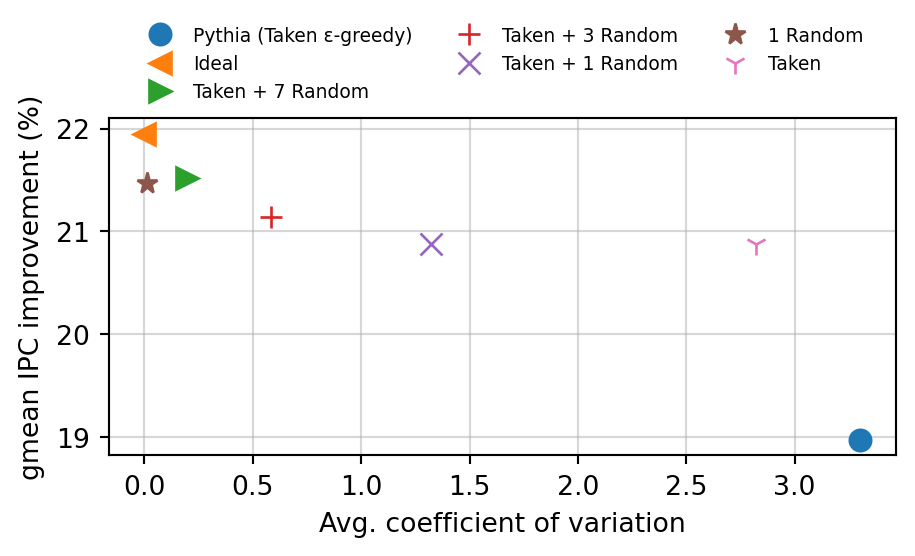

In [10]:
plot_variations_v2(skew_df, metric='cv', figsize=(5, 3))

In [13]:
plot_variations_v2(skew_df, metric='kldiv', figsize=(5, 3))
# plt.savefig('../../cvs/papers/micro-23r/figures/action_variance_vs_ipc.pdf')